# **TR_2021/01 - Technical report: Low humidity waves analysis for Campinas**


|Technical Report ID  |2021/01|
|--|--|
| Title |Low humidity waves: analysis for Campinas|
| Authors | Júlia De Lázari, Paula Dornhofer|
| Creation Date| 2021-01|

This report presents an analysis of the occurence of the extreme climatic event of Low humidity waves (LHW). This event is defined by three or more consecutive days with both minimum and maximum humidity below the 10th percentile.

## Database Description

The database used is from Viracopos (Campinas, SP), that has daily measures of minimum and maximum humidity, used to compute the LHW event. The database has data from 1983 until 2018.

An csv with the data already preprocessed was used in this analysis (**viracopos_humidity.csv**).

## Summary of analysis

The [climatex library](https://github.com/climate-and-health-datasci-Unicamp/py-climate-health-toolbox), developed to compute extreme climate events, was used to compute the waves and its yearly and seasonal metrics.

Trend analysis using Cox Stuart, Mann-Kendall and modified Mann-Kendall test were performed for yearly and seasonal metrics.

## Results

Low humidity waves are increasing in frequency, intensity and duration.


##**Import libraries**##

In [ ]:
#loading R magic
%load_ext rpy2.ipython

In [ ]:
#installing R packages
%%capture
%%R
install.packages('trend', repos='http://cran.rstudio.com/')
install.packages('modifiedmk',repos='http://cran.rstudio.com/')
install.packages('dplyr')
install.packages('randtests', repos = 'http://cran.rstudio.com/')

In [ ]:
#importing R libraries
%%R
library(readr)
library(modifiedmk)
library(trend)
library(dplyr)
library(randtests)

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [1]:
! git clone https://github.com/climate-and-health-datasci-Unicamp/py-climate-health-toolbox

Cloning into 'py-climate-health-toolbox'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (134/134), done.
Receiving objects: 100% (138/138), 7.88 MiB | 10.52 MiB/s, done.
remote: Total 138 (delta 68), reused 4 (delta 0), pack-reused 0
Resolving deltas: 100% (68/68), done.


In [ ]:
#import python libraries
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

#plots
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import seaborn as sns

#statsmodel
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

#climatex
import sys
sys.path.append('/content/py-climate-health-toolbox/climahe')
import climatex as tex

#files
from google.colab import drive
from google.colab import files

drive.mount('/content/drive')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/drive


##**Load data**

In [ ]:
#-------------------------------------------------------------------#
#                          Load Viracopos data                      #
#-------------------------------------------------------------------#

#Load humidity dataframe
df_vir = pd.read_csv('viracopos_humidity.csv')
df_vir = df_vir.drop(columns = {'Unnamed: 0'})
df_vir['DATE'] = pd.to_datetime(df_vir['DATE']) #to datetime
df_vir['YEAR'] = df_vir['DATE'].dt.strftime('%Y') #create column for year
df_vir = df_vir[(df_vir['DATE']<='2016-12-31') | (df_vir['DATE']>='2017-06-01')] #discard inconsistent data

In [ ]:
df_vir.dtypes

DATE    datetime64[ns]
HMIN             int64
HMAX             int64
YEAR            object
dtype: object

In [ ]:
#complete missing dates
df_vir = tex.complete_df(df_vir)
#pct of missing data
print(f"Percentage of missing data for minimum humidity: {round(100*len(df_vir[df_vir.HMIN.isnull()])/len(df_vir.HMIN),2)} %")
print(f"Percentage of missing data for maximum humidity: {round(100*len(df_vir[df_vir.HMAX.isnull()])/len(df_vir.HMAX),2)} %")

Percentage of missing data for minimum humidity: 3.33 %
Percentage of missing data for maximum humidity: 3.33 %


##**Computing waves**

Use climatex library to compute low humidity waves and yearly and seasonal metrics.

The period from 1983 to 2018 was used as climatic normal (compute percentiles) and database (compute waves and metrics).

In [ ]:
help(tex.check_LowHumidityWave)

Help on function check_LowHumidityWave in module climatex:

check_LowHumidityWave(database, db_columnMAX, db_columnMIN, climatic_normal, pct_columnMAX, pct_columnMIN, db_columnDay365=False, db_complete=False, cn_columnDay365=False, df_pct=None, percentile_value=0.1, window_size=15)
    #-------------------------------------------------------------------------------
    ## Checks for Low Humidity Waves on the database according to the Climatic Normal
    ##
    ## ## This function is inspired in Geirinhas et al. 2018 method for thermal waves and adapted
    ## for humidity waves. It obtains first a dataframe with the percentiles 
    ## computed from the Climatic Normal according to the defined window size (df_pct).
    ## Then compares it with the database, to check if the maximum and minimum values
    ## of humidity are below the corresponding percentile. If they are below the threshold,
    ## the column 'below_pct' receives 1. This column is then used to identify if there
    ## ar

In [ ]:
df_humidity,df_pct = tex.check_LowHumidityWave(df_vir,'HMAX','HMIN',df_vir,'HMAX','HMIN')

## **Yearly metrics**

In [ ]:
help(tex.wave_metrics)

Help on function wave_metrics in module climatex:

wave_metrics(df_checkW, wave_column, plot=False)
    #-------------------------------------------------------------------------------
    ## Function to obtain the yearly metrics of a Wave given the database
    ## dataframe containing the 'HW'/'CW'/'LPW'/'HPW'/'LHW'/'HHW' column that
    ## indicates if a day is inside of a Wave or not (check get_wave function).
    ## This function obtains the number of events (HWN/CWN/LPWN/HPWN/LHWN/HHWN),
    ## the event with maximum duration (HWD/CWD/LPWD/HPWD/LHWD/HHWD) and the 
    ## cumulative sum of wave durations (HWF/CWF/LPWF/HPWF/LHWF/HHWF) for each 
    ## year of the dataframe. These metrics are stored in a dataframe which includes the
    ## Wave metrics for each year of the database.
    ##
    ## It is possible to plot the metrics (plot=True). For a better adjustment of
    ## the plots, check function plot_oneMetric.
    ##
    ## :param      df_checkW:    Database dataframe with th

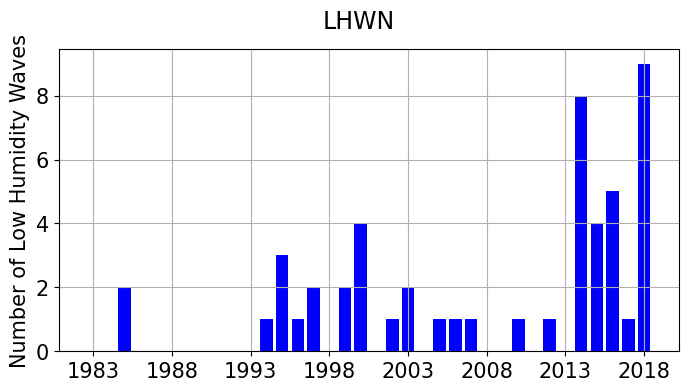

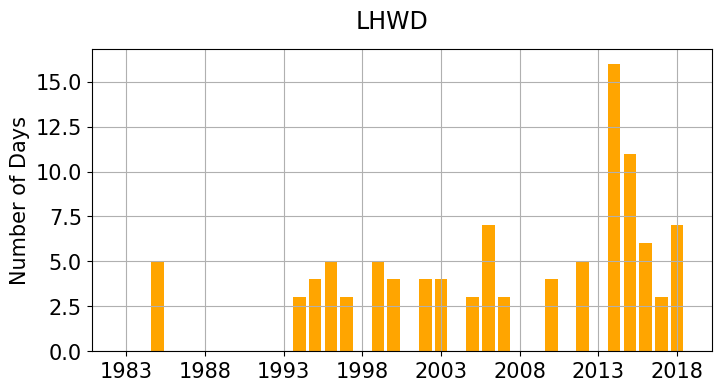

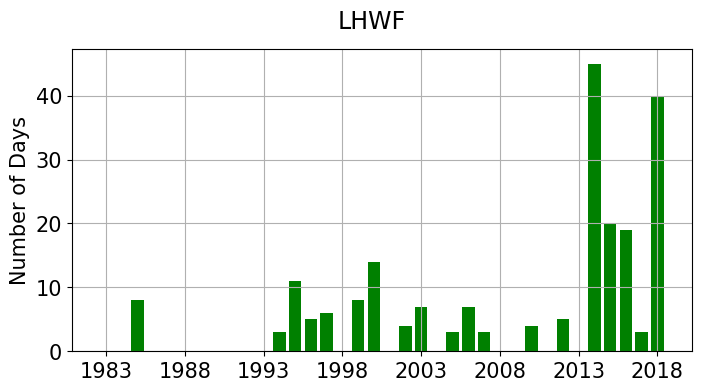

In [ ]:
#get yearly metrics
lhw_yearly = tex.wave_metrics(df_humidity,'LHW',True)

In [ ]:
lhw_yearly

,LHWN,LHWD,LHWF
YEAR,,,
1983,0.0,0.0,0.0
1984,0.0,0.0,0.0
1985,2.0,5.0,8.0
1986,0.0,0.0,0.0
1987,0.0,0.0,0.0
1988,0.0,0.0,0.0
1989,0.0,0.0,0.0
1990,0.0,0.0,0.0
1991,0.0,0.0,0.0


Descriptive of total time period

In [ ]:
df = lhw_yearly.describe()
df.loc['sum'] = lhw_yearly.sum()
df

,LHWN,LHWD,LHWF
count,36.000000,36.000000,36.000000
mean,1.388889,2.833333,5.972222
std,2.181451,3.573714,10.418352
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,1.000000,3.000000,3.000000
75%,2.000000,4.250000,7.000000
max,9.000000,16.000000,45.000000
sum,50.000000,102.000000,215.000000


Metrics in the three sub-periods of 12 years

**1983-1994**

In [ ]:
df = lhw_yearly[lhw_yearly.index <= 1994].describe()
df.loc['sum'] = lhw_yearly[lhw_yearly.index <= 1994].sum()
df

,LHWN,LHWD,LHWF
count,12.000000,12.000000,12.000000
mean,0.250000,0.666667,0.916667
std,0.621582,1.614330,2.391589
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,2.000000,5.000000,8.000000
sum,3.000000,8.000000,11.000000


**1995-2006**

In [ ]:
df = lhw_yearly[(lhw_yearly.index >= 1995) & (lhw_yearly.index <= 2006)].describe()
df.loc['sum'] = lhw_yearly[(lhw_yearly.index >= 1995) & (lhw_yearly.index <= 2006)].sum()
df

,LHWN,LHWD,LHWF
count,12.000000,12.00000,12.000000
mean,1.416667,3.25000,5.416667
std,1.240112,2.22077,4.399552
min,0.000000,0.00000,0.000000
25%,0.750000,2.25000,2.250000
50%,1.000000,4.00000,5.500000
75%,2.000000,4.25000,7.250000
max,4.000000,7.00000,14.000000
sum,17.000000,39.00000,65.000000


**2007-2018**

In [ ]:
df = lhw_yearly[lhw_yearly.index >= 2007].describe()
df.loc['sum'] = lhw_yearly[lhw_yearly.index >= 2007].sum()
df

,LHWN,LHWD,LHWF
count,12.000000,12.000000,12.000000
mean,2.500000,4.583333,11.583333
std,3.233349,4.944388,16.053651
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,1.000000,3.500000,3.500000
75%,4.250000,6.250000,19.250000
max,9.000000,16.000000,45.000000
sum,30.000000,55.000000,139.000000


##**Seasonal Metrics**

In [ ]:
help(tex.wave_seasonMetrics)

Help on function wave_seasonMetrics in module climatex:

wave_seasonMetrics(df_checkW, wave_column, plot=False)
    #-------------------------------------------------------------------------------
    ## Function to obtain the seasonal metrics of a Wave given the
    ## database dataframe containing the 'HW'/'CW'/'LPW'/'HPW'/'LHW'/'HHW' column
    ## that indicates if a day is part of a Wave or not (check get_wave function).
    ## This function obtains the number of events (HWN/CWN/LPWN/HPWN/LHWN/HHWN),
    ## the event with maximum duration (HWD/CWD/LPWD/HPWD/LHWD/HHWD) and the
    ## cumulative sum of wave durations (HWF/CWF/LPWF/HPWF/LHWF/HHWF) for all seasons
    ## (summer, autumn, winter and spring) of each year of the dataframe. These
    ## metrics are stored in a dataframe which includes the Wave metrics
    ## for each year of the database, separated by seasons.
    ##
    ## The calendar year adopted is from december of previous year until november of
    ## actual year.
  

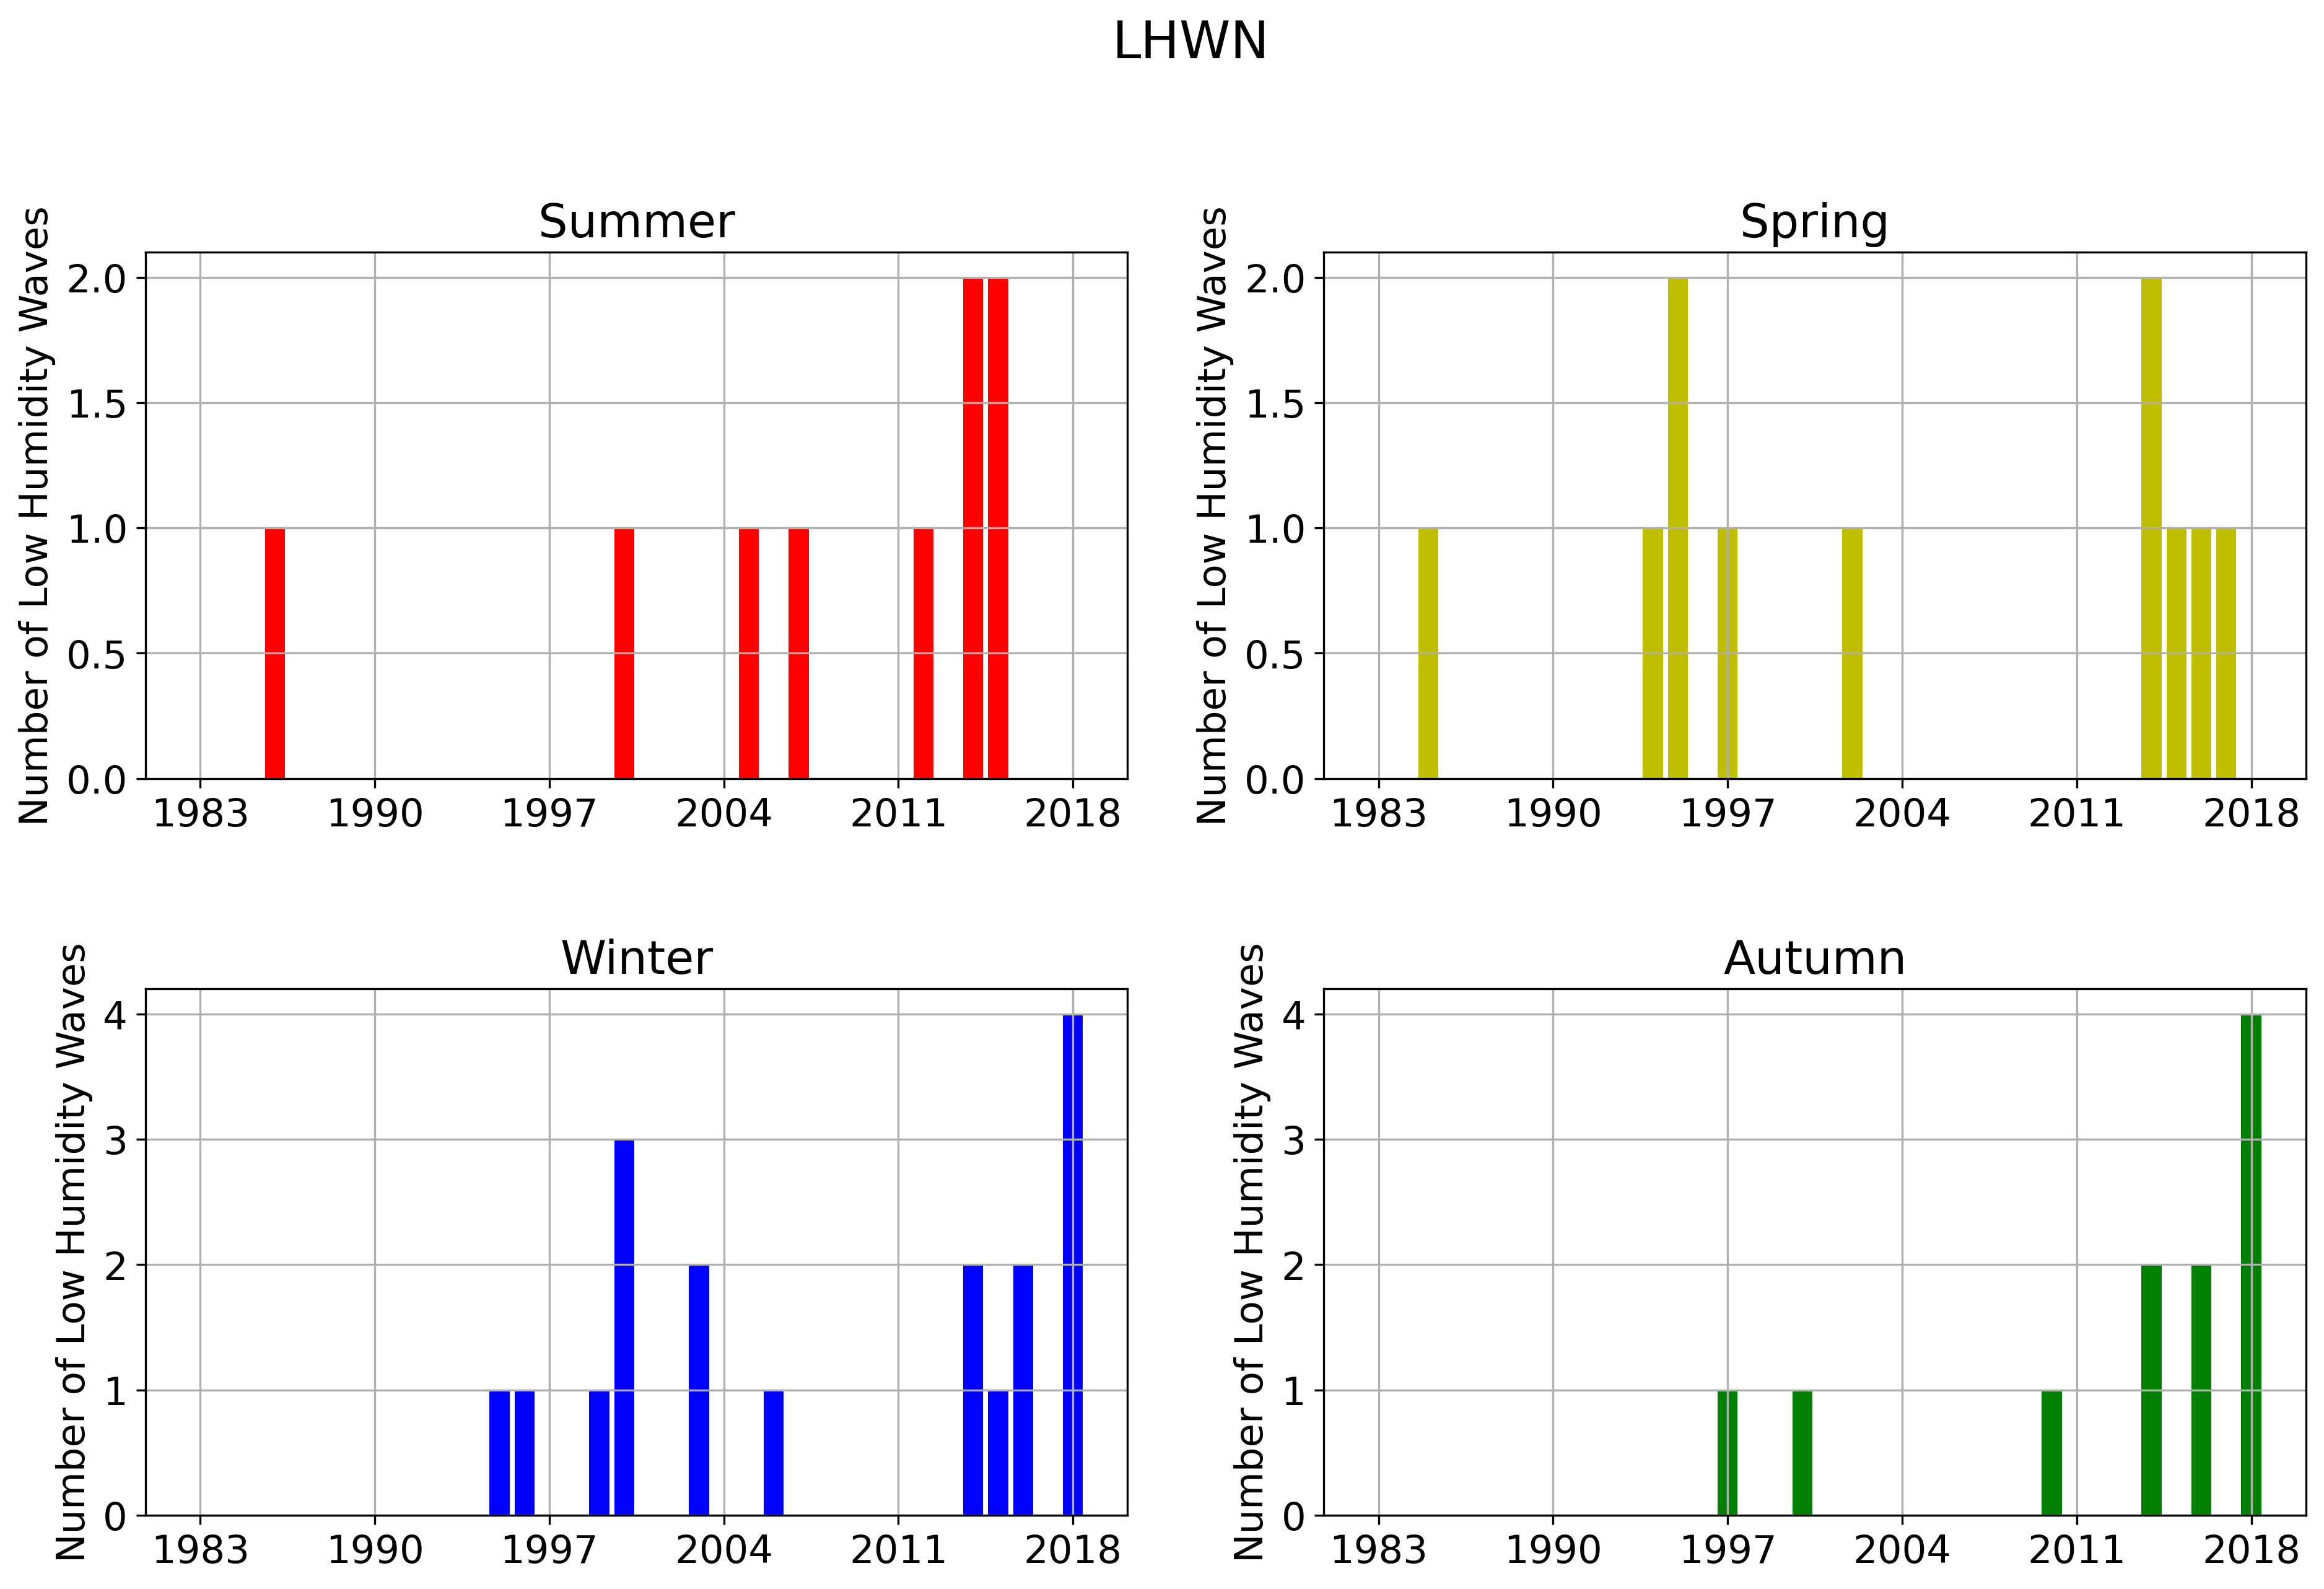

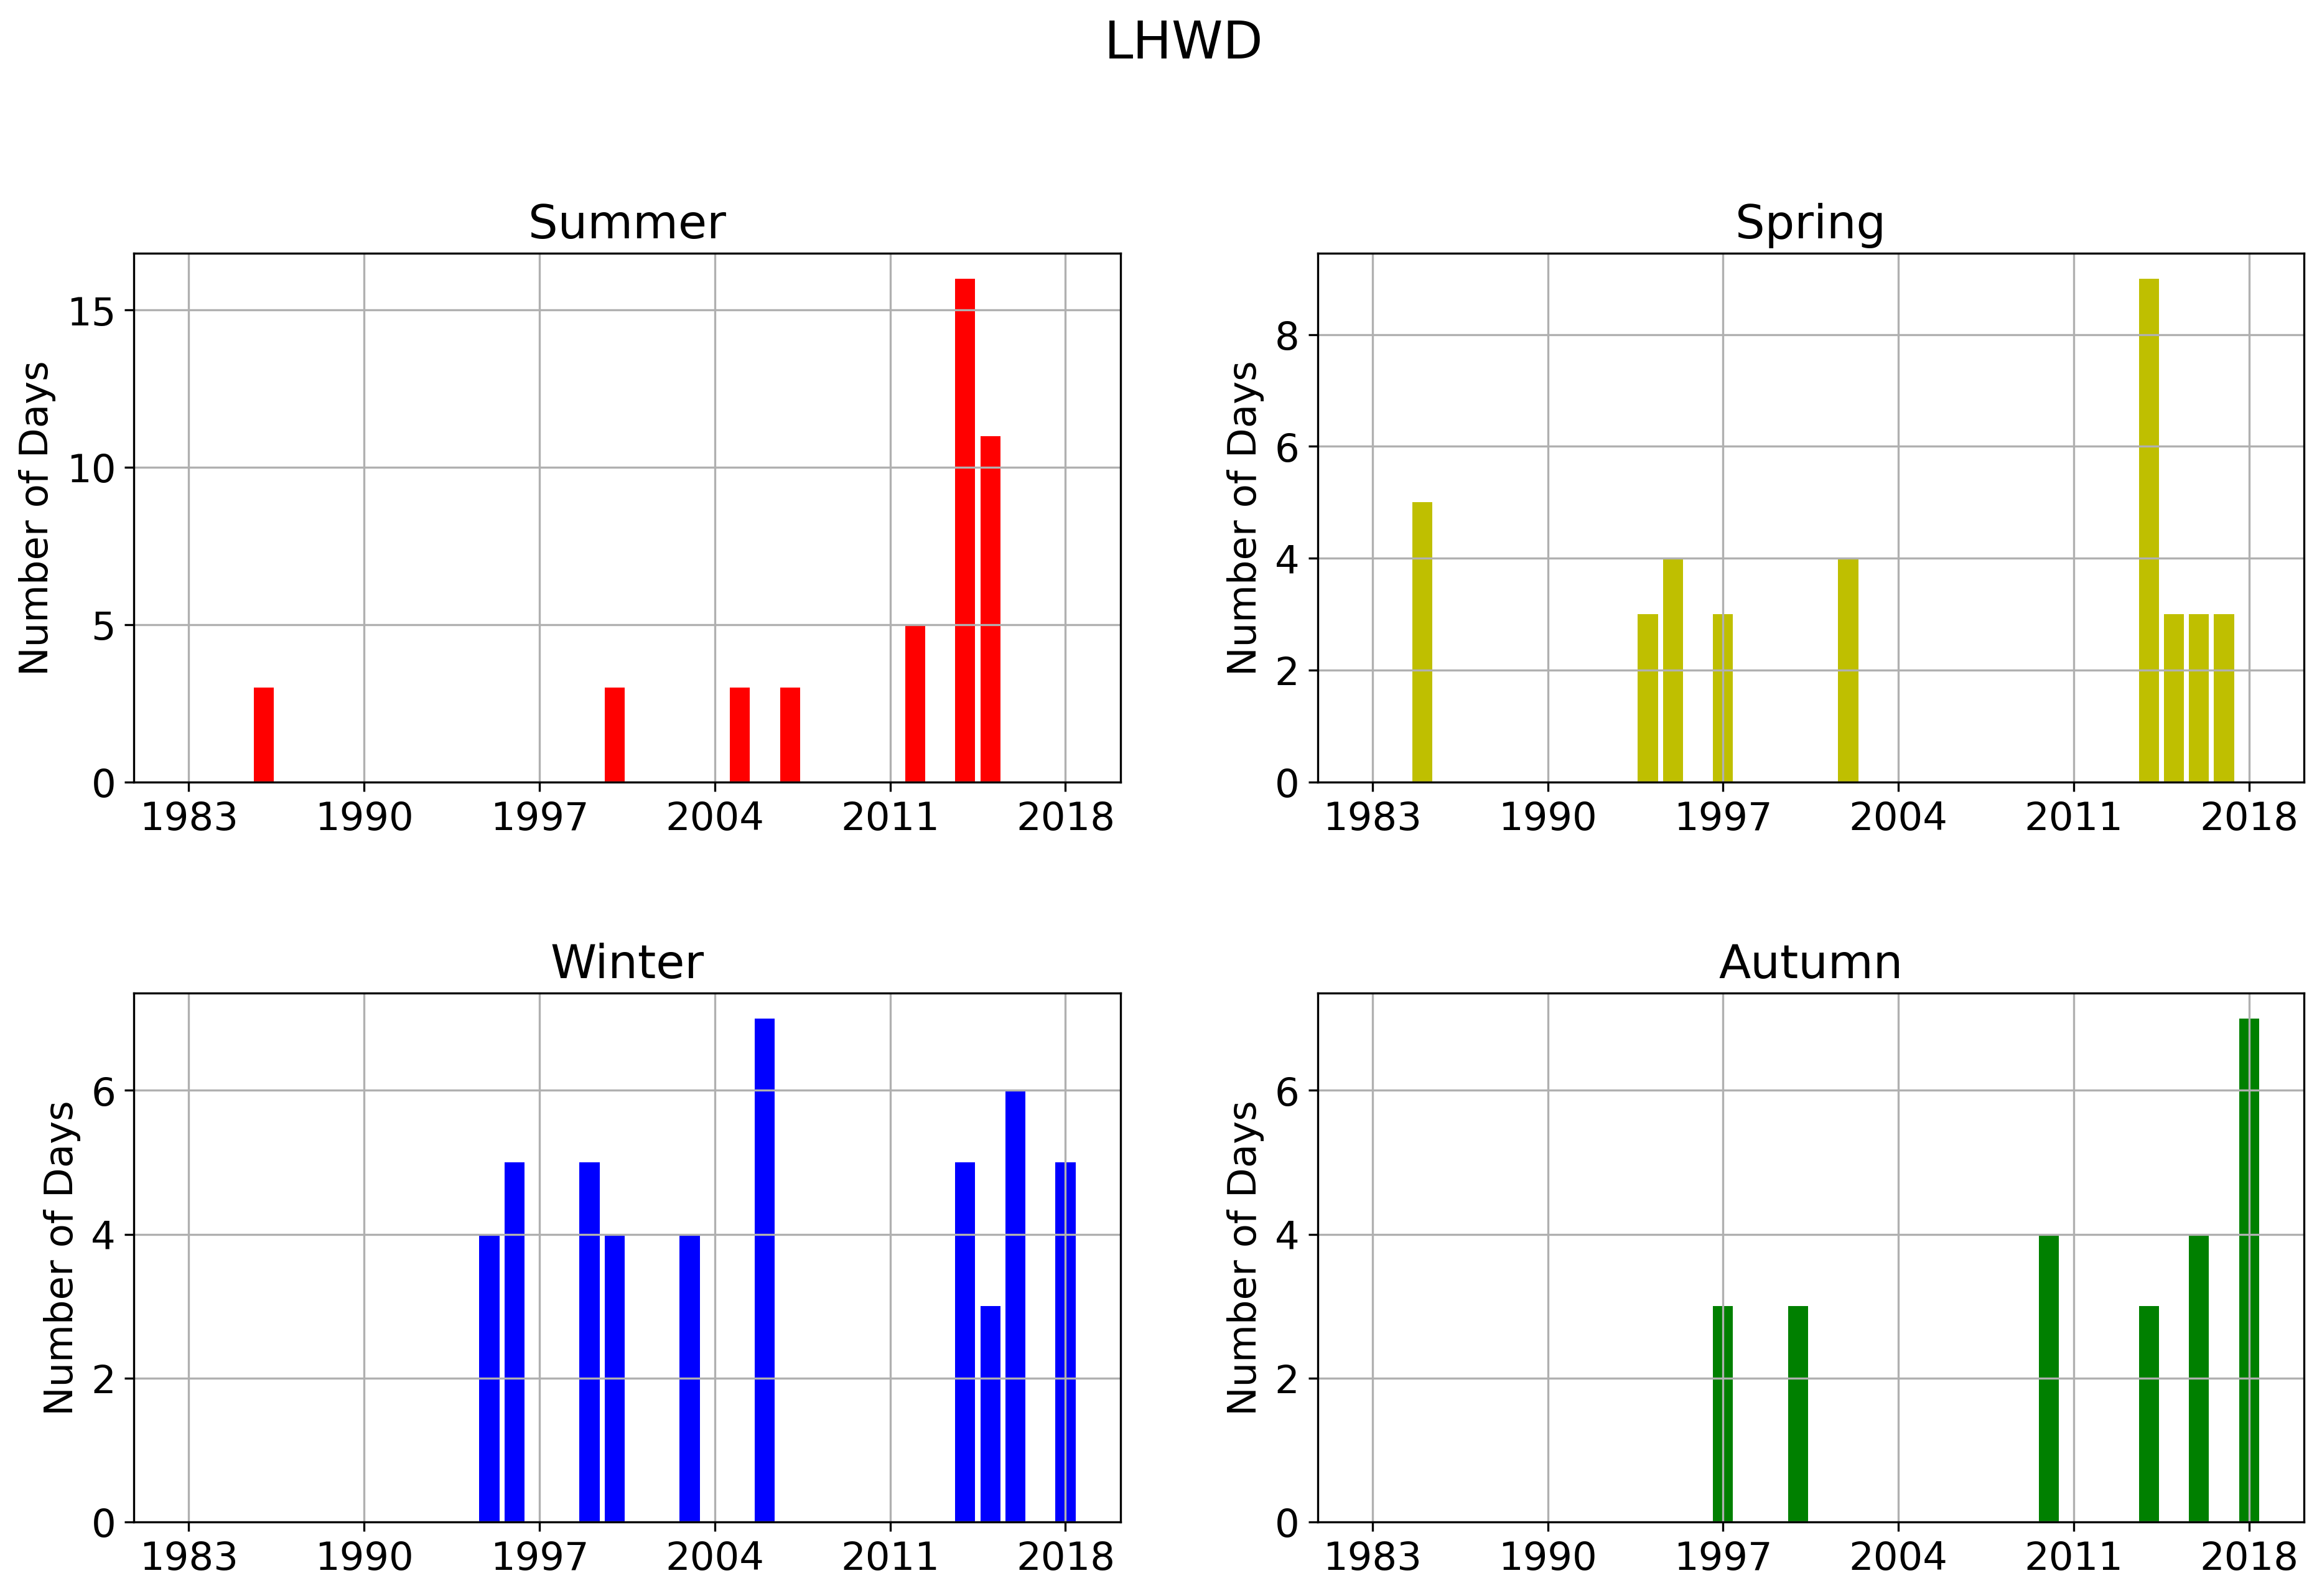

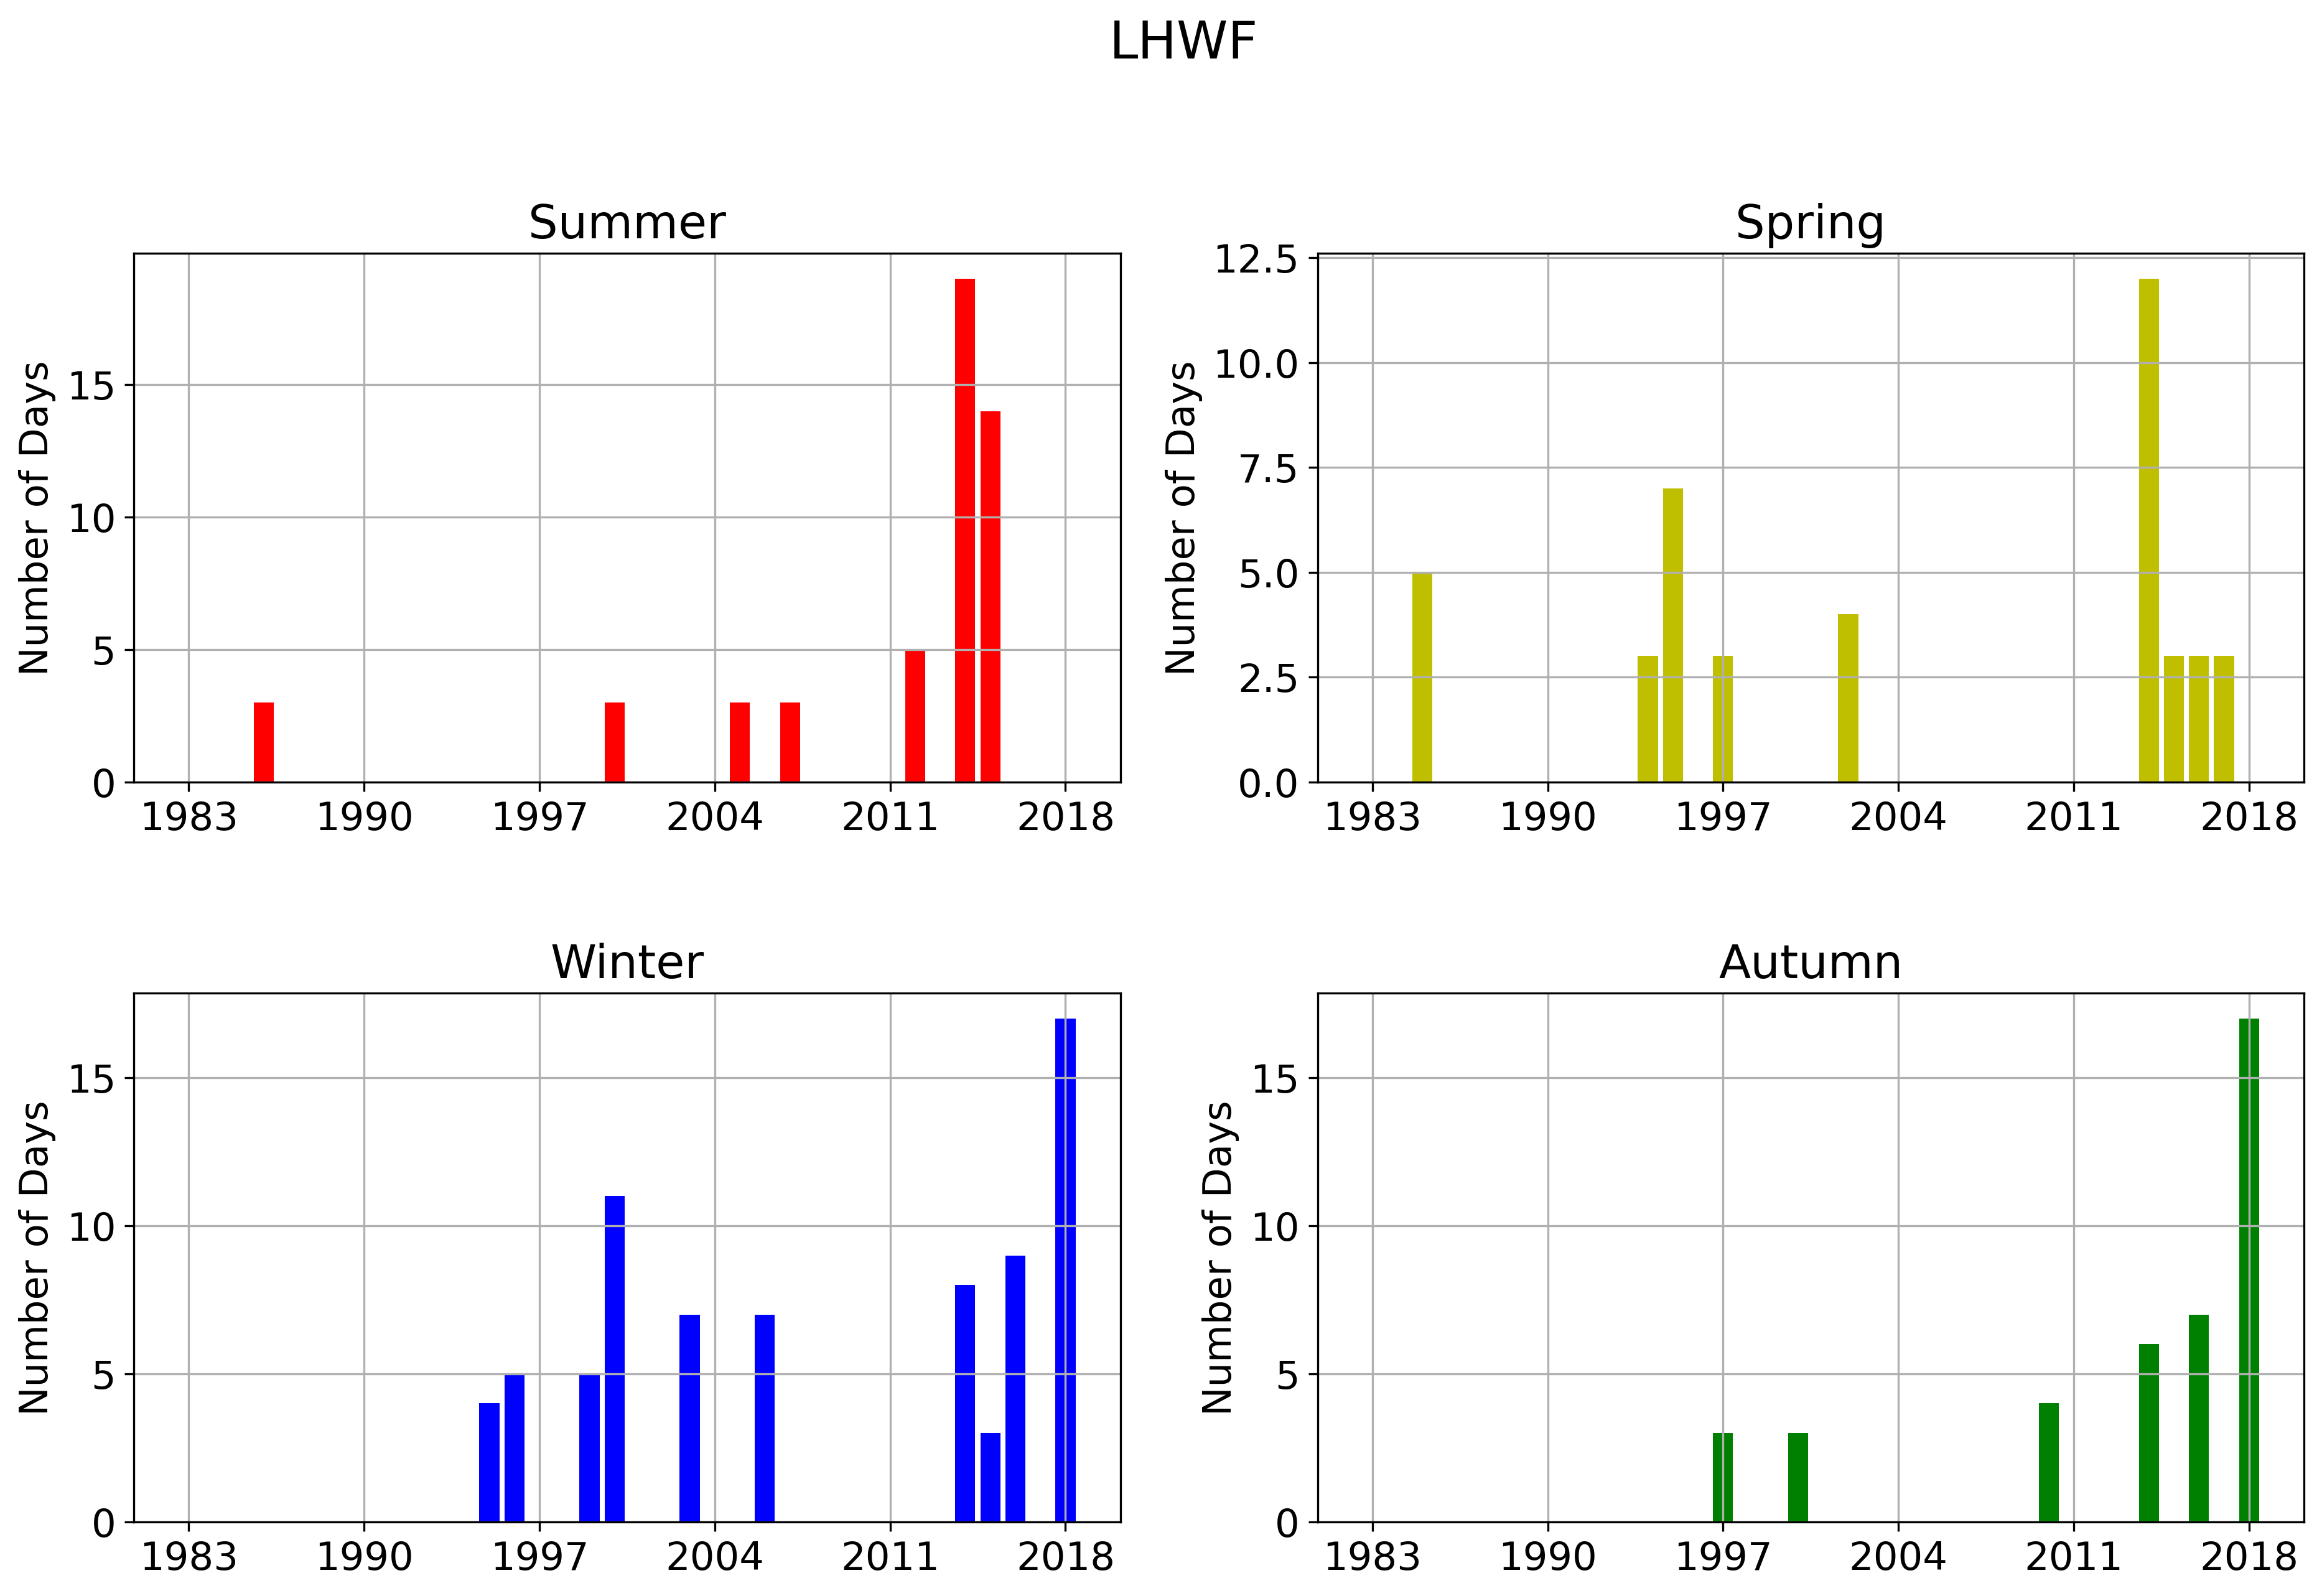

In [ ]:
lhw_season = tex.wave_seasonMetrics(df_humidity,'LHW',True)

###**Summer**

In [ ]:
df = lhw_season.xs('1', level=1).describe()
df.loc['sum'] = lhw_season.xs('1', level=1).sum()
df

,LHWN,LHWD,LHWF
count,36.000000,36.000000,36.000000
mean,0.250000,1.222222,1.388889
std,0.554205,3.313273,3.958916
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,2.000000,16.000000,19.000000
sum,9.000000,44.000000,50.000000


**1983-1994**

In [ ]:
df = lhw_season.xs('1', level=1)[(lhw_season.xs('1', level=1).index<=1994)].describe()
df.loc['sum'] = lhw_season.xs('1', level=1)[lhw_season.xs('1', level=1).index <=1994].sum()
df

,LHWN,LHWD,LHWF
count,12.000000,12.000000,12.000000
mean,0.083333,0.250000,0.250000
std,0.288675,0.866025,0.866025
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,1.000000,3.000000,3.000000
sum,1.000000,3.000000,3.000000


**1995-2006**

In [ ]:
df = lhw_season.xs('1', level=1)[(lhw_season.xs('1', level=1).index >= 1995) & (lhw_season.xs('1', level=1).index <= 2006)].describe()
df.loc['sum'] = lhw_season.xs('1', level=1)[(lhw_season.xs('1', level=1).index >= 1995) & (lhw_season.xs('1', level=1).index <= 2006)].sum()
df

,LHWN,LHWD,LHWF
count,12.000000,12.000000,12.000000
mean,0.166667,0.500000,0.500000
std,0.389249,1.167748,1.167748
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,1.000000,3.000000,3.000000
sum,2.000000,6.000000,6.000000


**2007-2018**

In [ ]:
df = lhw_season.xs('1', level=1)[(lhw_season.xs('1', level=1).index >= 2007)].describe()
df.loc['sum'] = lhw_season.xs('1', level=1)[lhw_season.xs('1', level=1).index >= 2007].sum()
df

,LHWN,LHWD,LHWF
count,12.000000,12.000000,12.000000
mean,0.500000,2.916667,3.416667
std,0.797724,5.299371,6.402533
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,3.500000,3.500000
max,2.000000,16.000000,19.000000
sum,6.000000,35.000000,41.000000


###**Autumn**

In [ ]:
df = lhw_season.xs('2', level=1).describe()
df.loc['sum'] = lhw_season.xs('2', level=1).sum()
df

,LHWN,LHWD,LHWF
count,36.000000,36.000000,36.000000
mean,0.305556,0.666667,1.111111
std,0.821825,1.621287,3.222934
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,4.000000,7.000000,17.000000
sum,11.000000,24.000000,40.000000


**1983-2000**

In [ ]:
df = lhw_season.xs('2', level=1)[(lhw_season.xs('2', level=1).index<=1994)].describe()
df.loc['sum'] = lhw_season.xs('2', level=1)[lhw_season.xs('2', level=1).index <= 1994].sum()
df

,LHWN,LHWD,LHWF
count,12.0,12.0,12.0
mean,0.0,0.0,0.0
std,0.0,0.0,0.0
min,0.0,0.0,0.0
25%,0.0,0.0,0.0
50%,0.0,0.0,0.0
75%,0.0,0.0,0.0
max,0.0,0.0,0.0
sum,0.0,0.0,0.0


**1995-2006**

In [ ]:
df = lhw_season.xs('2', level=1)[(lhw_season.xs('2', level=1).index >= 1995) & (lhw_season.xs('2', level=1).index <= 2006)].describe()
df.loc['sum'] = lhw_season.xs('2', level=1)[(lhw_season.xs('2', level=1).index >= 1995) & (lhw_season.xs('2', level=1).index <= 2006)].sum()
df

,LHWN,LHWD,LHWF
count,12.000000,12.000000,12.000000
mean,0.166667,0.500000,0.500000
std,0.389249,1.167748,1.167748
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,1.000000,3.000000,3.000000
sum,2.000000,6.000000,6.000000


**2007-2018**

In [ ]:
df = lhw_season.xs('2', level=1)[(lhw_season.xs('2', level=1).index >= 2007)].describe()
df.loc['sum'] = lhw_season.xs('2', level=1)[lhw_season.xs('2', level=1).index >= 2007].sum()
df

,LHWN,LHWD,LHWF
count,12.000000,12.000000,12.000000
mean,0.750000,1.500000,2.833333
std,1.288057,2.393172,5.166911
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.250000,3.250000,4.500000
max,4.000000,7.000000,17.000000
sum,9.000000,18.000000,34.000000


###**Winter**

In [ ]:
df = lhw_season.xs('3', level=1).describe()
df.loc['sum'] = lhw_season.xs('3', level=1).sum()
df

,LHWN,LHWD,LHWF
count,36.000000,36.000000,36.000000
mean,0.500000,1.333333,2.111111
std,0.971008,2.255153,4.026894
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,3.250000,3.250000
max,4.000000,7.000000,17.000000
sum,18.000000,48.000000,76.000000


**1983-1994**

In [ ]:
df = lhw_season.xs('3', level=1)[(lhw_season.xs('3', level=1).index<=1994)].describe()
df.loc['sum'] = lhw_season.xs('3', level=1)[lhw_season.xs('3', level=1).index <= 1994].sum()
df

,LHWN,LHWD,LHWF
count,12.0,12.0,12.0
mean,0.0,0.0,0.0
std,0.0,0.0,0.0
min,0.0,0.0,0.0
25%,0.0,0.0,0.0
50%,0.0,0.0,0.0
75%,0.0,0.0,0.0
max,0.0,0.0,0.0
sum,0.0,0.0,0.0


**1995-2006**

In [ ]:
df = lhw_season.xs('3', level=1)[(lhw_season.xs('3', level=1).index >= 1995) & (lhw_season.xs('3', level=1).index <= 2006)].describe()
df.loc['sum'] = lhw_season.xs('3', level=1)[(lhw_season.xs('3', level=1).index >= 1995) & (lhw_season.xs('3', level=1).index <= 2006)].sum()
df

,LHWN,LHWD,LHWF
count,12.000000,12.000000,12.000000
mean,0.750000,2.416667,3.250000
std,0.965307,2.644319,3.792936
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.500000,2.000000,2.000000
75%,1.000000,4.250000,5.500000
max,3.000000,7.000000,11.000000
sum,9.000000,29.000000,39.000000


**2007-2018**

In [ ]:
df = lhw_season.xs('3', level=1)[(lhw_season.xs('3', level=1).index >= 2007)].describe()
df.loc['sum'] = lhw_season.xs('3', level=1)[lhw_season.xs('3', level=1).index >= 2007].sum()
df

,LHWN,LHWD,LHWF
count,12.000000,12.000000,12.000000
mean,0.750000,1.583333,3.083333
std,1.288057,2.429303,5.468228
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.250000,3.500000,4.250000
max,4.000000,6.000000,17.000000
sum,9.000000,19.000000,37.000000


###**Spring**

In [ ]:
df = lhw_season.xs('4', level=1).describe()
df.loc['sum'] = lhw_season.xs('4', level=1).sum()
df

,LHWN,LHWD,LHWF
count,36.000000,36.000000,36.000000
mean,0.305556,1.027778,1.194444
std,0.576663,2.035206,2.550288
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.250000,0.750000,0.750000
max,2.000000,9.000000,12.000000
sum,11.000000,37.000000,43.000000


**1983-1994**

In [ ]:
df = lhw_season.xs('4', level=1)[(lhw_season.xs('4', level=1).index<=1994)].describe()
df.loc['sum'] = lhw_season.xs('4', level=1)[lhw_season.xs('4', level=1).index <= 1994].sum()
df

,LHWN,LHWD,LHWF
count,12.000000,12.000000,12.000000
mean,0.166667,0.666667,0.666667
std,0.389249,1.614330,1.614330
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,1.000000,5.000000,5.000000
sum,2.000000,8.000000,8.000000


**1995-2006**

In [ ]:
df = lhw_season.xs('4', level=1)[(lhw_season.xs('4', level=1).index >= 1995) & (lhw_season.xs('4', level=1).index <= 2006)].describe()
df.loc['sum'] = lhw_season.xs('4', level=1)[(lhw_season.xs('4', level=1).index >= 1995) & (lhw_season.xs('4', level=1).index <= 2006)].sum()
df

,LHWN,LHWD,LHWF
count,12.000000,12.000000,12.000000
mean,0.333333,0.916667,1.166667
std,0.651339,1.676486,2.289634
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.250000,0.750000,0.750000
max,2.000000,4.000000,7.000000
sum,4.000000,11.000000,14.000000


**2007-2018**

In [ ]:
df = lhw_season.xs('4', level=1)[(lhw_season.xs('4', level=1).index >= 2007)].describe()
df.loc['sum'] = lhw_season.xs('4', level=1)[lhw_season.xs('4', level=1).index >= 2007].sum()
df

,LHWN,LHWD,LHWF
count,12.000000,12.000000,12.0000
mean,0.416667,1.500000,1.7500
std,0.668558,2.713602,3.4935
min,0.000000,0.000000,0.0000
25%,0.000000,0.000000,0.0000
50%,0.000000,0.000000,0.0000
75%,1.000000,3.000000,3.0000
max,2.000000,9.000000,12.0000
sum,5.000000,18.000000,21.0000


##**Trend analysis: yearly metrics**

###**Autocorrelation plots**

An autocorrelation plot shows whether the elements of a time series are positively correlated, negatively correlated, or independent of each other. The vertical axis shows the value of the autocorrelation function (acf), that can range from -1 to 1. The horizontal axis of an autocorrelation plot shows the size of the lag between the elements of the time series.  Each spike that rises above or falls below the shaded are is considered to be statistically significant.

We obtained the autocorrelation plot for each metric. We can observe that almost all lags (lag 0 is 1 per definition) are under the shaded area. This indicates that the data is not significantly correlated.

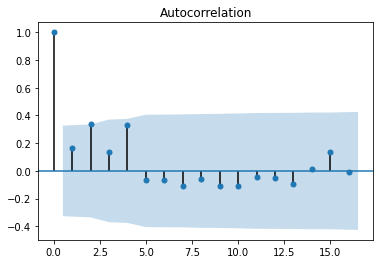

In [ ]:
#number of waves
plot_acf(lhw_yearly.LHWN.dropna())
plt.show()

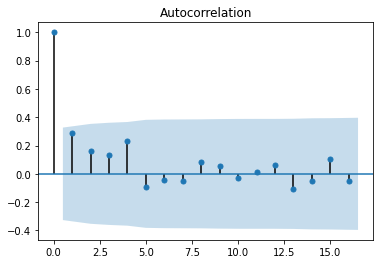

In [ ]:
#longest wave
plot_acf(lhw_yearly.LHWD.dropna())
plt.show()

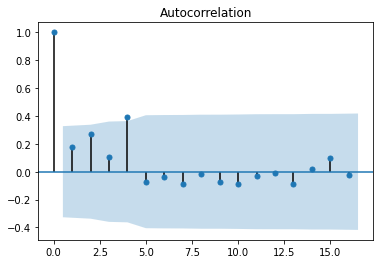

In [ ]:
#total number of days under wave
plot_acf(lhw_yearly.LHWF.dropna())
plt.show()

In [ ]:
#loading metrics data in R
%%R
R_humidity <- read.csv('/content/drive/Shared drives/Clima&Saúde/Pesquisadores/DeLázari_Júlia/data/Climáticos_Viracopos/LHW/LHW_yearly_metrics.csv', header = TRUE)
R_humidity <- R_humidity[ -c(0:1)]

head(R_humidity)

  LHWN LHWD LHWF
1    0    0    0
2    0    0    0
3    2    5    8
4    0    0    0
5    0    0    0
6    0    0    0


###**Cox - Stuart test**

The Cox-Stuart test is defined as a little powerful test, but very robust for the trend analysis [Cox e Stuart, 1955].

Data is grouped in pairs with the ith observation of the first half paired with the ith observation of the second half of the time-ordered data. If the length of vector X is odd the middle observation is eliminated. The cox stuart test is then simply a sign test applied to these paired data.

Based on the plots of yearly metrics, we tested for increasing trend ("right.sided") of the low humidity waves metrics (LHWN, LHWD, LHWF) and obtained a stastically significant result for all of them.


**LHWN**

In [ ]:
%%R
cox.stuart.test(R_humidity$LHWN,'right.sided')


	Cox Stuart test

data:  R_humidity$LHWN
statistic = 9, n = 11, p-value = 0.03271
alternative hypothesis: increasing trend



**LHWD**

In [ ]:
%%R
cox.stuart.test(R_humidity$LHWD,'right.sided')


	Cox Stuart test

data:  R_humidity$LHWD
statistic = 10, n = 13, p-value = 0.04614
alternative hypothesis: increasing trend



**LHWF**

In [ ]:
%%R
cox.stuart.test(R_humidity$LHWF,'right.sided')


	Cox Stuart test

data:  R_humidity$LHWF
statistic = 10, n = 13, p-value = 0.04614
alternative hypothesis: increasing trend



###**Mann Kendall**

Non parametric test used to evaluate trends in time series [Mann 1945].

- Null hypothesis (H0): data is independent and identically distributed (no trend)
- Alternative hypothesis (H1): data is **not** independent and identically distributed (possible trend)

The Mann-Kendall tests are based on the calculation of Kendall's tau measure of association between two samples, which is itself based on the ranks with the samples. The computations assume that the observations are independent.

As some correlation was found between data, we also applied Trend Free
Pre-Whitening method - TFPW to account for this correlation [Yue, Pilon e Cavadias 2002, Blain 2014].

**LHWN**

In [ ]:
#applying original Mann-Kendall test
%%R
mkttest(R_humidity$LHWN)

     Z-Value  Sen's slope            S       Var(S)      P-value          Tau 
2.684201e+00 3.279570e-02 1.850000e+02 4.699000e+03 7.270329e-03 2.936508e-01 


In [ ]:
#applying trend-free pre-whitening modified Mann-Kendall test
%%R
tfpwmk(R_humidity$LHWN)

        Z-Value     Sen's Slope Old Sen's Slope         P-value               S 
   2.613063e+00    3.814899e-02    3.279570e-02    8.973463e-03    1.850000e+02 
         Var(S)             Tau 
   4.958333e+03    3.109244e-01 


**LHWD**

In [ ]:
#applying original Mann-Kendall test
%%R
mkttest(R_humidity$LHWD)

     Z-Value  Sen's slope            S       Var(S)      P-value          Tau 
2.899566e+00 1.091270e-01 2.010000e+02 4.757667e+03 3.736797e-03 3.190476e-01 


In [ ]:
#applying trend-free pre-whitening modified Mann-Kendall test
%%R
tfpwmk(R_humidity$LHWD)

        Z-Value     Sen's Slope Old Sen's Slope         P-value               S 
   2.669869e+00    1.090199e-01    1.091270e-01    7.588079e-03    1.890000e+02 
         Var(S)             Tau 
   4.958333e+03    3.176471e-01 


**LHWF**

In [ ]:
#applying original Mann-Kendall test
%%R
mkttest(R_humidity$LHWF)

     Z-Value  Sen's slope            S       Var(S)      P-value          Tau 
2.644685e+00 1.428571e-01 1.840000e+02 4.788000e+03 8.176690e-03 2.920635e-01 


In [ ]:
#applying trend-free pre-whitening modified Mann-Kendall test
%%R
tfpwmk(R_humidity$LHWF)

        Z-Value     Sen's Slope Old Sen's Slope         P-value               S 
   2.542313e+00    1.675793e-01    1.428571e-01    1.101216e-02    1.800000e+02 
         Var(S)             Tau 
   4.957333e+03    3.025210e-01 


##**Trend analysis: seasonal metrics**

In [ ]:
#loading metrics data in R
%%R
R_humidity_season <- read.csv('/content/drive/Shared drives/Clima&Saúde/Pesquisadores/DeLázari_Júlia/data/Climáticos_Viracopos/LHW/LHW_season_metrics.csv', header = TRUE)
R_humidity_season <- R_humidity_season[ -c(0:1)]

head(R_humidity_season)

  SEASON LHWN LHWD LHWF
1      1    0    0    0
2      2    0    0    0
3      3    0    0    0
4      4    0    0    0
5      1    0    0    0
6      2    0    0    0


###**Summer**
No statistically significant trend was found

**Cox stuart**

In [ ]:
%%R
print('mktest LHWN:')
print(cox.stuart.test(R_humidity_season[R_humidity_season$SEASON == "1",]$LHWN, 'right.sided'))

writeLines('')

print('mktest LHWD:')
print(cox.stuart.test(R_humidity_season[R_humidity_season$SEASON == "1",]$LHWD, 'right.sided'))

writeLines('')

print('mktest LWNF:')
print(cox.stuart.test(R_humidity_season[R_humidity_season$SEASON == "1",]$LHWF, 'right.sided'))

[1] "mktest LHWN:"

	Cox Stuart test

data:  R_humidity_season[R_humidity_season$SEASON == "1", ]$LHWN
statistic = 5, n = 7, p-value = 0.2266
alternative hypothesis: increasing trend


[1] "mktest LHWD:"

	Cox Stuart test

data:  R_humidity_season[R_humidity_season$SEASON == "1", ]$LHWD
statistic = 5, n = 7, p-value = 0.2266
alternative hypothesis: increasing trend


[1] "mktest LWNF:"

	Cox Stuart test

data:  R_humidity_season[R_humidity_season$SEASON == "1", ]$LHWF
statistic = 5, n = 7, p-value = 0.2266
alternative hypothesis: increasing trend



**Mann Kendall**

In [ ]:
#original mann kendall test
%%R
print('mktest LHWN:')
print(mkttest(R_humidity_season[R_humidity_season$SEASON == "1",]$LHWN))

writeLines('')

print('mktest LHWD:')
print(mkttest(R_humidity_season[R_humidity_season$SEASON == "1",]$LHWD))

writeLines('')

print('mktest LWNF:')
print(mkttest(R_humidity_season[R_humidity_season$SEASON == "1",]$LHWF))

[1] "mktest LHWN:"
     Z-Value  Sen's slope            S       Var(S)      P-value          Tau 
   1.5903808    0.0000000   81.0000000 2530.3333333    0.1117490    0.1285714 

[1] "mktest LHWD:"
     Z-Value  Sen's slope            S       Var(S)      P-value          Tau 
1.647093e+00 0.000000e+00 8.400000e+01 2.539333e+03 9.953884e-02 1.333333e-01 

[1] "mktest LWNF:"
     Z-Value  Sen's slope            S       Var(S)      P-value          Tau 
1.647093e+00 0.000000e+00 8.400000e+01 2.539333e+03 9.953884e-02 1.333333e-01 


**Modified Mann Kendall**

In [ ]:
%%R
print('tfpwmk LHWN:')
print(tfpwmk(R_humidity_season[R_humidity_season$SEASON == "1",]$LHWN))

writeLines('')

print('tfpwmk LHWD:')
print(tfpwmk(R_humidity_season[R_humidity_season$SEASON == "1",]$LHWD))

writeLines('')

print('tfpwmk LWNF:')
print(tfpwmk(R_humidity_season[R_humidity_season$SEASON == "1",]$LHWF))

[1] "tfpwmk LHWN:"
        Z-Value     Sen's Slope Old Sen's Slope         P-value               S 
   3.137462e-01    0.000000e+00    0.000000e+00    7.537138e-01    2.000000e+01 
         Var(S)             Tau 
   3.667333e+03    3.361345e-02 

[1] "tfpwmk LHWD:"
        Z-Value     Sen's Slope Old Sen's Slope         P-value               S 
   3.130640e-01    0.000000e+00    0.000000e+00    7.542321e-01    2.000000e+01 
         Var(S)             Tau 
   3.683333e+03    3.361345e-02 

[1] "tfpwmk LWNF:"
        Z-Value     Sen's Slope Old Sen's Slope         P-value               S 
   3.130640e-01    0.000000e+00    0.000000e+00    7.542321e-01    2.000000e+01 
         Var(S)             Tau 
   3.683333e+03    3.361345e-02 


###**Autumn**
No statistically significant trend was found

**Cox stuart**

In [ ]:
%%R
print('mktest LHWN:')
print(cox.stuart.test(R_humidity_season[R_humidity_season$SEASON == "2",]$LHWN, 'right.sided'))

writeLines('')

print('mktest LHWD:')
print(cox.stuart.test(R_humidity_season[R_humidity_season$SEASON == "2",]$LHWD, 'right.sided'))

writeLines('')

print('mktest LWNF:')
print(cox.stuart.test(R_humidity_season[R_humidity_season$SEASON == "2",]$LHWF, 'right.sided'))

[1] "mktest LHWN:"

	Cox Stuart test

data:  R_humidity_season[R_humidity_season$SEASON == "2", ]$LHWN
statistic = 4, n = 5, p-value = 0.1875
alternative hypothesis: increasing trend


[1] "mktest LHWD:"

	Cox Stuart test

data:  R_humidity_season[R_humidity_season$SEASON == "2", ]$LHWD
statistic = 4, n = 5, p-value = 0.1875
alternative hypothesis: increasing trend


[1] "mktest LWNF:"

	Cox Stuart test

data:  R_humidity_season[R_humidity_season$SEASON == "2", ]$LHWF
statistic = 4, n = 5, p-value = 0.1875
alternative hypothesis: increasing trend



**Mann Kendall**

In [ ]:
#original mann kendall test
%%R
print('mktest LHWN:')
print(mkttest(R_humidity_season[R_humidity_season$SEASON == "2",]$LHWN))

writeLines('')

print('mktest LHWD:')
print(mkttest(R_humidity_season[R_humidity_season$SEASON == "2",]$LHWD))

writeLines('')

print('mktest LWNF:')
print(mkttest(R_humidity_season[R_humidity_season$SEASON == "2",]$LHWF))

[1] "mktest LHWN:"
     Z-Value  Sen's slope            S       Var(S)      P-value          Tau 
2.406721e+00 0.000000e+00 1.150000e+02 2.243667e+03 1.609648e-02 1.825397e-01 

[1] "mktest LHWD:"
     Z-Value  Sen's slope            S       Var(S)      P-value          Tau 
2.364497e+00 0.000000e+00 1.130000e+02 2.243667e+03 1.805455e-02 1.793651e-01 

[1] "mktest LWNF:"
     Z-Value  Sen's slope            S       Var(S)      P-value          Tau 
2.468040e+00 0.000000e+00 1.180000e+02 2.247333e+03 1.358553e-02 1.873016e-01 


In [ ]:
%%R
print('tfpwmk LHWN:')
print(tfpwmk(R_humidity_season[R_humidity_season$SEASON == "2",]$LHWN))

writeLines('')

print('tfpwmk LHWD:')
print(tfpwmk(R_humidity_season[R_humidity_season$SEASON == "2",]$LHWD))

writeLines('')

print('tfpwmk LWNF:')
print(tfpwmk(R_humidity_season[R_humidity_season$SEASON == "2",]$LHWF))

[1] "tfpwmk LHWN:"
        Z-Value     Sen's Slope Old Sen's Slope         P-value               S 
   3.260987e+00    0.000000e+00    0.000000e+00    1.110250e-03    1.890000e+02 
         Var(S)             Tau 
   3.323667e+03    3.176471e-01 

[1] "tfpwmk LHWD:"
        Z-Value     Sen's Slope Old Sen's Slope         P-value               S 
   3.191605e+00    0.000000e+00    0.000000e+00    1.414848e-03    1.850000e+02 
         Var(S)             Tau 
   3.323667e+03    3.109244e-01 

[1] "tfpwmk LWNF:"
        Z-Value     Sen's Slope Old Sen's Slope         P-value               S 
   3.361355e+00    0.000000e+00    0.000000e+00    7.756100e-04    1.950000e+02 
         Var(S)             Tau 
   3.331000e+03    3.277311e-01 


###**Winter**
No statistically significant trend was found

**Cox stuart**

In [ ]:
%%R
print('mktest LHWN:')
print(cox.stuart.test(R_humidity_season[R_humidity_season$SEASON == "3",]$LHWN, 'right.sided'))

writeLines('')

print('mktest LHWD:')
print(cox.stuart.test(R_humidity_season[R_humidity_season$SEASON == "3",]$LHWD, 'right.sided'))

writeLines('')

print('mktest LWNF:')
print(cox.stuart.test(R_humidity_season[R_humidity_season$SEASON == "3",]$LHWF, 'right.sided'))

[1] "mktest LHWN:"

	Cox Stuart test

data:  R_humidity_season[R_humidity_season$SEASON == "3", ]$LHWN
statistic = 6, n = 8, p-value = 0.1445
alternative hypothesis: increasing trend


[1] "mktest LHWD:"

	Cox Stuart test

data:  R_humidity_season[R_humidity_season$SEASON == "3", ]$LHWD
statistic = 5, n = 7, p-value = 0.2266
alternative hypothesis: increasing trend


[1] "mktest LWNF:"

	Cox Stuart test

data:  R_humidity_season[R_humidity_season$SEASON == "3", ]$LHWF
statistic = 6, n = 8, p-value = 0.1445
alternative hypothesis: increasing trend



**Mann Kendall**

In [ ]:
#original mann kendall test
%%R
print('mktest LHWN:')
print(mkttest(R_humidity_season[R_humidity_season$SEASON == "3",]$LHWN))

writeLines('')

print('mktest LHWD:')
print(mkttest(R_humidity_season[R_humidity_season$SEASON == "3",]$LHWD))

writeLines('')

print('mktest LWNF:')
print(mkttest(R_humidity_season[R_humidity_season$SEASON == "3",]$LHWF))

[1] "mktest LHWN:"
     Z-Value  Sen's slope            S       Var(S)      P-value          Tau 
2.241756e+00 0.000000e+00 1.300000e+02 3.311333e+03 2.497717e-02 2.063492e-01 

[1] "mktest LHWD:"
     Z-Value  Sen's slope            S       Var(S)      P-value          Tau 
2.065483e+00 0.000000e+00 1.200000e+02 3.319333e+03 3.887737e-02 1.904762e-01 

[1] "mktest LWNF:"
     Z-Value  Sen's slope            S       Var(S)      P-value          Tau 
2.322226e+00 0.000000e+00 1.350000e+02 3.329667e+03 2.022079e-02 2.142857e-01 


In [ ]:
%%R
print('tfpwmk LHWN:')
print(tfpwmk(R_humidity_season[R_humidity_season$SEASON == "3",]$LHWN))

writeLines('')

print('tfpwmk LHWD:')
print(tfpwmk(R_humidity_season[R_humidity_season$SEASON == "3",]$LHWD))

writeLines('')

print('tfpwmk LWNF:')
print(tfpwmk(R_humidity_season[R_humidity_season$SEASON == "3",]$LHWF))

[1] "tfpwmk LHWN:"
        Z-Value     Sen's Slope Old Sen's Slope         P-value               S 
      1.1697991       0.0000000       0.0000000       0.2420818      75.0000000 
         Var(S)             Tau 
   4001.6666667       0.1260504 

[1] "tfpwmk LHWD:"
        Z-Value     Sen's Slope Old Sen's Slope         P-value               S 
      1.0906223       0.0000000       0.0000000       0.2754391      70.0000000 
         Var(S)             Tau 
   4002.6666667       0.1176471 

[1] "tfpwmk LWNF:"
        Z-Value     Sen's Slope Old Sen's Slope         P-value               S 
   2.622615e+00    0.000000e+00    0.000000e+00    8.725780e-03    1.670000e+02 
         Var(S)             Tau 
   4.006333e+03    2.806723e-01 


###**Spring**
No statistically significant trend was found

**Cox stuart**

In [ ]:
%%R
print('mktest LHWN:')
print(cox.stuart.test(R_humidity_season[R_humidity_season$SEASON == "4",]$LHWN, 'right.sided'))

writeLines('')

print('mktest LHWD:')
print(cox.stuart.test(R_humidity_season[R_humidity_season$SEASON == "4",]$LHWD, 'right.sided'))

writeLines('')

print('mktest LWNF:')
print(cox.stuart.test(R_humidity_season[R_humidity_season$SEASON == "4",]$LHWF, 'right.sided'))

[1] "mktest LHWN:"

	Cox Stuart test

data:  R_humidity_season[R_humidity_season$SEASON == "4", ]$LHWN
statistic = 4, n = 7, p-value = 0.5
alternative hypothesis: increasing trend


[1] "mktest LHWD:"

	Cox Stuart test

data:  R_humidity_season[R_humidity_season$SEASON == "4", ]$LHWD
statistic = 4, n = 7, p-value = 0.5
alternative hypothesis: increasing trend


[1] "mktest LWNF:"

	Cox Stuart test

data:  R_humidity_season[R_humidity_season$SEASON == "4", ]$LHWF
statistic = 4, n = 7, p-value = 0.5
alternative hypothesis: increasing trend



**Mann Kendall**

In [ ]:
#original mann kendall test
%%R
print('mktest LHWN:')
print(mkttest(R_humidity_season[R_humidity_season$SEASON == "4",]$LHWN))

writeLines('')

print('mktest LHWD:')
print(mkttest(R_humidity_season[R_humidity_season$SEASON == "4",]$LHWD))

writeLines('')

print('mktest LWNF:')
print(mkttest(R_humidity_season[R_humidity_season$SEASON == "4",]$LHWF))

[1] "mktest LHWN:"
     Z-Value  Sen's slope            S       Var(S)      P-value          Tau 
1.051307e+00 0.000000e+00 5.900000e+01 3.043667e+03 2.931177e-01 9.365079e-02 

[1] "mktest LHWD:"
     Z-Value  Sen's slope            S       Var(S)      P-value          Tau 
9.202519e-01 0.000000e+00 5.200000e+01 3.071333e+03 3.574412e-01 8.253968e-02 

[1] "mktest LWNF:"
     Z-Value  Sen's slope            S       Var(S)      P-value          Tau 
9.381433e-01 0.000000e+00 5.300000e+01 3.072333e+03 3.481708e-01 8.412698e-02 


In [ ]:
%%R
print('tfpwmk LHWN:')
print(tfpwmk(R_humidity_season[R_humidity_season$SEASON == "4",]$LHWN))

writeLines('')

print('tfpwmk LHWD:')
print(tfpwmk(R_humidity_season[R_humidity_season$SEASON == "4",]$LHWD))

writeLines('')

print('tfpwmk LWNF:')
print(tfpwmk(R_humidity_season[R_humidity_season$SEASON == "4",]$LHWF))

[1] "tfpwmk LHWN:"
        Z-Value     Sen's Slope Old Sen's Slope         P-value               S 
   7.903911e-01    0.000000e+00    0.000000e+00    4.292994e-01    5.000000e+01 
         Var(S)             Tau 
   3.843333e+03    8.403361e-02 

[1] "tfpwmk LHWD:"
        Z-Value     Sen's Slope Old Sen's Slope         P-value               S 
   8.372227e-01    0.000000e+00    0.000000e+00    4.024674e-01    5.300000e+01 
         Var(S)             Tau 
   3.857667e+03    8.907563e-02 

[1] "tfpwmk LWNF:"
        Z-Value     Sen's Slope Old Sen's Slope         P-value               S 
   8.210159e-01    0.000000e+00    0.000000e+00    4.116372e-01    5.200000e+01 
         Var(S)             Tau 
   3.858667e+03    8.739496e-02 


## **References**

BLAIN, G. C. Removing the influence of the serial correlation on the mann-kendall test. Revista Brasileira de Meteorologia, SciELO Brasil, v. 29, n. 2, p. 161–170, 2014.

COX, D. R.; STUART, A. Some quick sign tests for trend in location and dispersion. Biometrika, JSTOR, v. 42, n. 1/2, p. 80–95, 1955.

MANN, H. B. Nonparametric tests against trend.Econometrica: Journal of the econometric society, JSTOR, p. 245–259, 1945.

YUE, S.; PILON, P.; CAVADIAS, G. Power of the mann–kendall and spearman’s rho testsfor detecting monotonic trends in hydrological series. Journal of hydrology, Elsevier, v. 259,n. 1-4, p. 254–271, 2002
